In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [131]:
import IPython
from IPython.display import display

import io
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import PIL
import cv2

import sneks
import gym

import torch
import torch.nn as nn

DEVICE = 'cpu'

torch.__version__, torch.cuda.is_available()

('1.3.1', True)

In [132]:
env = gym.make('snek-rgb-16-v1')

observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)

env.action_space, env.observation_space

(Discrete(4), Box(16, 16, 3))

In [133]:
# https://github.com/NicksonYap/Jupyter-Webcam/blob/master/Realtime_video_ipython_py3.ipynb
def show_array(a, prev_display_id=None, fmt='jpeg'):
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    IPython.display.display(obj)

In [134]:
def show_live_env(env, controller, duration=100, fps=100):
    try:
        total_frames = 0
        
        while True:
            f = 0
            obs = env.reset()

            while True:
                total_frames += 1
                IPython.display.clear_output(wait=True)
                time.sleep(1 / fps)
                f += 1

                action = controller(f, obs)
                obs, _, done, _ = env.step(action)
                frame = env.render('rgb_array')
                show_array(frame)

                if done: break
                if total_frames >= duration: return

    except KeyboardInterrupt:
        show_array(frame) # show last frame
        print('stream interrupted')

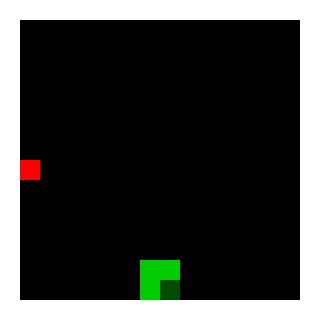

In [135]:
show_live_env(env, lambda e, o: env.action_space.sample(), duration=80, fps=200)

# Utils

In [136]:
def shift_episode(episode):
    return np.concatenate([
        episode[1:],
        np.ones((1, *episode[0].shape))
    ])

In [137]:
def preprocess_episodes(batch):
    episodes = [o / 255 for o, a, r in batch]

    # Flatten episodes
    next_obs = torch.FloatTensor([o for e in episodes for o in shift_episode(e)])
    obs = torch.FloatTensor([o for e in episodes for o in e])
    actions = torch.LongTensor([a for _, actions, _ in batch for a in actions])
    rewards = torch.FloatTensor([r for _, _, rewards in batch for r in rewards])

    next_obs = next_obs.reshape(-1, obs_size).to(DEVICE)
    obs = obs.reshape(-1, obs_size).to(DEVICE)
    actions = actions.reshape(-1).to(DEVICE)
    rewards = rewards.reshape(-1).to(DEVICE)
    
    return obs, actions, rewards, next_obs

In [138]:
def dqn_loss(model, batch):
    criterion = nn.MSELoss()
    obs, actions, rewards, next_obs = preprocess_episodes(batch)
    q_vals = model(obs).index_select(dim=1, index=actions)[0]
    next_q_vals = model(next_obs).max(dim=1)[0]
    target_q_vals = next_q_vals * discount + rewards

    return criterion(q_vals, target_q_vals)

In [139]:
def dense(i, o, a=nn.Sigmoid):
    l = nn.Linear(i, o)
    return nn.Sequential(l, a())

# Model

In [140]:
obs_size = 16 * 16 * 3
num_actions = 4
hidden_dim = 256
discount = 0.999

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()

        self.net = nn.Sequential(
            nn.Flatten(),
            dense(obs_size, hidden_dim, nn.ReLU),
            dense(hidden_dim, hidden_dim, nn.ReLU),
            dense(hidden_dim, hidden_dim, nn.ReLU),
            dense(hidden_dim, hidden_dim, nn.ReLU),
            nn.Linear(hidden_dim, num_actions),
        ).to(DEVICE)

        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=0.001)

    def forward(self, obs):
        return self.net(obs)
        
    def get_max_action(self, obs):
        obs = obs[np.newaxis, ...] / 255
        obs = torch.FloatTensor(obs).to(DEVICE)
        q_vals = self.net(obs)[0]

        return q_vals.argmax().cpu().detach().numpy()


dqn = DQN()

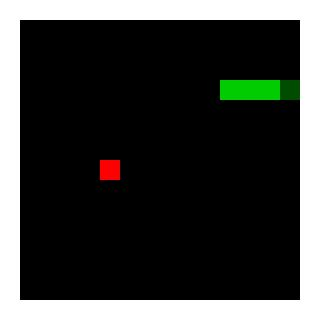

In [141]:
def dqn_controller(f, obs):
    return dqn.get_max_action(obs)

show_live_env(env, dqn_controller, duration=80, fps=200)

# Experience provider

In [142]:
def play_episode(env, model):
    max_rollout_steps = 1000
    ee_tradeoff = 0.2
    obs = env.reset()
    all_obs = []
    all_actions = []
    all_rewards = []
    use_model = random.random() > ee_tradeoff

    for _ in range(max_rollout_steps):
        if use_model:
            max_action = model.get_max_action(obs)
        else:
            max_action = env.action_space.sample()

        obs, reward, done, info = env.step(max_action)
        all_obs.append(obs)
        all_actions.append(max_action)
        all_rewards.append(reward)
        if done: break

    return (
        np.array(all_obs),
        np.array(all_actions),
        np.array(all_rewards),
    )

obs, actions, rewards = play_episode(env, dqn)
obs.shape, actions.shape, rewards.shape

((6, 16, 16, 3), (6,), (6,))

# Training

In [143]:
from collections import deque

def dqn_optimize(env, model):
    experience_pool = deque()
    max_experiences = 50
    its =  300
    bs = 32

    def optimization_step():
        # batch = experience_pool[-bs:]
        batch = random.sample(
            experience_pool,
            min(len(experience_pool), bs)
        )

        model.optimizer.zero_grad()
        loss = dqn_loss(model, batch)
        loss.backward()
        model.optimizer.step()

        return loss.item()


    tr = trange(its, bar_format='{bar} {desc}')
    for i in tr:
        episode = play_episode(env, model)
        experience_pool.append(episode)
        
        loss = optimization_step()
        
        description = [
            'it %i/%i' % (i + 1, its),
            'loss: %.6f' % loss,
            'avg episode len: %.2f' % np.mean([len(e[0]) for e in experience_pool])
        ]
        
        tr.set_description(' | '.join(description))

        if len(experience_pool) > max_experiences:
            experience_pool.popleft()

In [144]:
dqn_optimize(env, dqn)

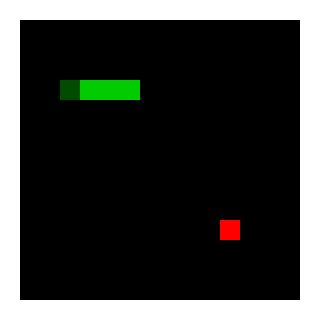

stream interrupted


In [145]:
show_live_env(env, dqn_controller, duration=800, fps=10)